# Data Exploration

Analyzing the structure, quality, and key characteristics of historical crude oil production data for PADD 2 (R20), we Midwest region including  Illinois, Indiana, Iowa, Kansas, Kentucky, Michigan, Minnesota, Missouri, Nebraska, North Dakota, South Dakota, Ohio, Oklahoma, Tennessee, and Wisconsin. This region is known for its growing refining capacity and historically has been a key area for fuel production and distribution, with a significant amount of oil refined there coming from Canadian oil fields.

The dataset was sourced from the official U.S. Energy Information Administration (EIA), ensuring reliability and accuracy.

https://www.eia.gov/opendata/browser/petroleum/crd/crpdn?frequency=monthly&data=value;&start=1960-01&sortColumn=period;&sortDirection=desc;

### 1-Imports and Setup

In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('muted')

In [2]:
load_dotenv()
API_KEY = os.getenv('EIA_API_KEY')

### 2-Data loading

In [46]:
#API request for PADD 2 (R20)
base_url = (
    'https://api.eia.gov/v2/petroleum/crd/crpdn/data/'
    '?api_key={}'
    '&frequency=monthly'
    '&data[0]=value'
    '&facets[duoarea][]=R20'
    '&start=1960-01'
    '&sort[0][column]=period'
    '&sort[0][direction]=asc'
    '&offset={}'
    '&length=5000'
)

all_records = []
offset = 0

while True:
    url = base_url.format(API_KEY, offset)
    response = requests.get(url)
    
    if response.status_code !=200:
        print(f"Error at offset {offset}: {response.status_code}")
        break
    
    data = response.json()
    records = data['response']['data']
    all_records.extend(records)
    
    if len(records) < 5000:
        break
    
    offest += 5000
    
#Processing data and saving it
if all_records:
    df = pd.DataFrame(all_records)
    df['period'] = pd.to_datetime(df['period'])
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df.to_csv('../data/raw/padd2_oil_production_1960_present.csv', index=False)
    print(f"Succefully saved {len(df)} records to padd2_oil_production.csv")
else:
    print("No data found. Check your API key and requrest parameters.")

Succefully saved 1068 records to padd2_oil_production.csv


In [47]:
#preview of data
df.head()

,period,duoarea,area-name,product,product-name,process,process-name,series,series-description,value,units
0,1981-01-01,R20,PADD 2,EPC0,Crude Oil,FPF,Field Production,MCRFPP22,Midwest (PADD 2) Field Production of Crude Oil...,926,MBBL/D
1,1981-01-01,R20,PADD 2,EPC0,Crude Oil,FPF,Field Production,MCRFPP21,Midwest (PADD 2) Field Production of Crude Oil...,28698,MBBL
2,1981-02-01,R20,PADD 2,EPC0,Crude Oil,FPF,Field Production,MCRFPP21,Midwest (PADD 2) Field Production of Crude Oil...,27285,MBBL
3,1981-02-01,R20,PADD 2,EPC0,Crude Oil,FPF,Field Production,MCRFPP22,Midwest (PADD 2) Field Production of Crude Oil...,974,MBBL/D
4,1981-03-01,R20,PADD 2,EPC0,Crude Oil,FPF,Field Production,MCRFPP22,Midwest (PADD 2) Field Production of Crude Oil...,976,MBBL/D


### 3-Basic Data Overview

In [48]:
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
df.info()
df.describe().T

Rows: 1068, Columns: 11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   period              1068 non-null   datetime64[ns]
 1   duoarea             1068 non-null   object        
 2   area-name           1068 non-null   object        
 3   product             1068 non-null   object        
 4   product-name        1068 non-null   object        
 5   process             1068 non-null   object        
 6   process-name        1068 non-null   object        
 7   series              1068 non-null   object        
 8   series-description  1068 non-null   object        
 9   value               1068 non-null   int64         
 10  units               1068 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 91.9+ KB


,count,mean,min,25%,50%,75%,max,std
period,1068,2003-03-17 12:32:21.573033728,1981-01-01 00:00:00,1992-02-01 00:00:00,2003-03-16 12:00:00,2014-05-01 00:00:00,2025-06-01 00:00:00,NaN
value,1068.0,15729.996255,412.0,790.0,7234.5,24287.5,72737.0,18864.789067


### 4-Quality Checks

In [49]:
# Missing value check
missing = df.isnull().sum()
print("Missing values per column:", missing[missing>0])

Missing values per column: Series([], dtype: int64)


In [50]:
#Duplicate check
duplicates = df.duplicated().sum()
print("Duplicate rows :", duplicates)

Duplicate rows : 0


### 5-Data preprocessing

In [51]:
#Sorting data by period
df['period'] = pd.to_datetime(df['period'])
df = df.sort_values(by='period').reset_index(drop=True)

#Filtering data for main product (Crude Oil + Field Production)
df_main = df[(df['product-name'] == 'Crude Oil') &
             (df['process-name'] == 'Field Production')]

#Creating pivot table
pivot_df = df_main.pivot_table(index='period',
                         columns='units',
                         values='value',
                         aggfunc='sum')

pivot_df.head(25)

units,MBBL,MBBL/D
period,,
1981-01-01,28698,926
1981-02-01,27285,974
1981-03-01,30245,976
1981-04-01,28789,960
1981-05-01,30033,969
1981-06-01,29710,990
1981-07-01,28674,925
1981-08-01,30946,998
1981-09-01,30472,1016


### 6-Visualization

#### Production over time

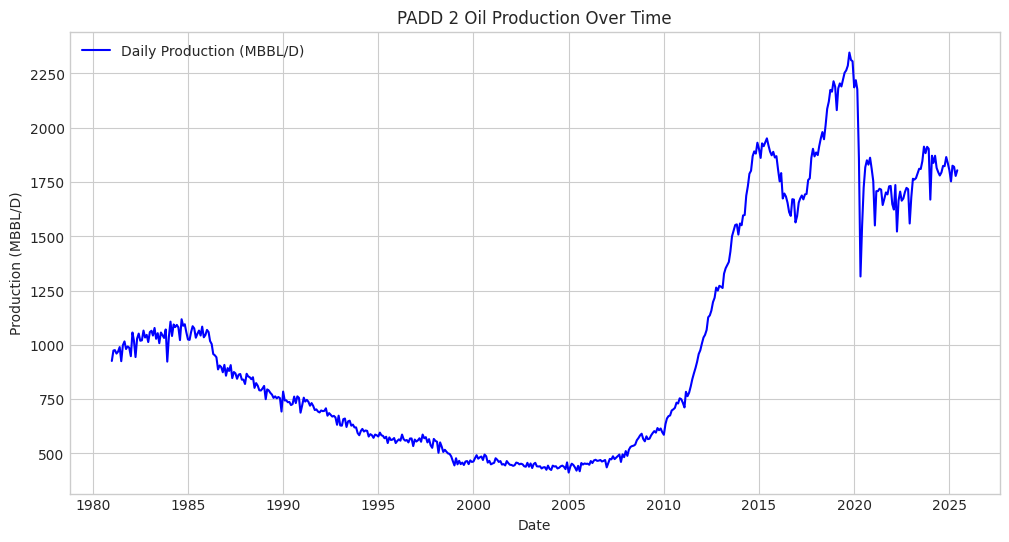

In [52]:
plt.figure(figsize=(12,6))
plt.plot(pivot_df.index, pivot_df['MBBL/D'], label='Daily Production (MBBL/D)', color='blue')
plt.title('PADD 2 Oil Production Over Time')
plt.xlabel('Date')
plt.ylabel('Production (MBBL/D)')
plt.legend()
plt.show() 

#### Rolling average to observe trends

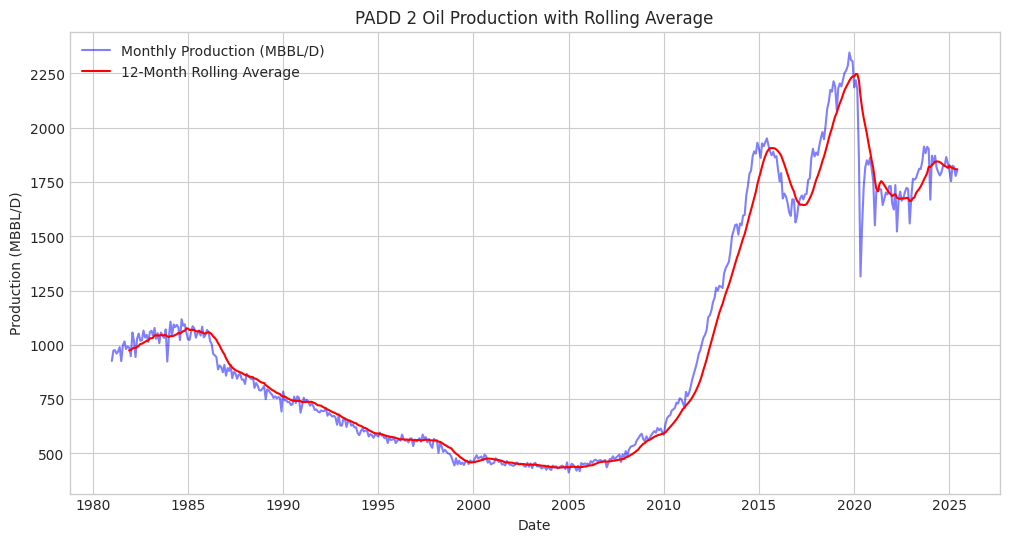

In [53]:
pivot_df['Rolling_Avg_12m'] = pivot_df['MBBL/D'].rolling(window=12).mean()
plt.figure(figsize=(12,6))
plt.plot(pivot_df.index, pivot_df['MBBL/D'], label='Monthly Production (MBBL/D)', color='blue', alpha=0.5)
plt.plot(pivot_df.index, pivot_df['Rolling_Avg_12m'], label='12-Month Rolling Average', color='red')
plt.title('PADD 2 Oil Production with Rolling Average')
plt.xlabel('Date')
plt.ylabel('Production (MBBL/D)')
plt.legend()
plt.show()

#### Seasonal plot

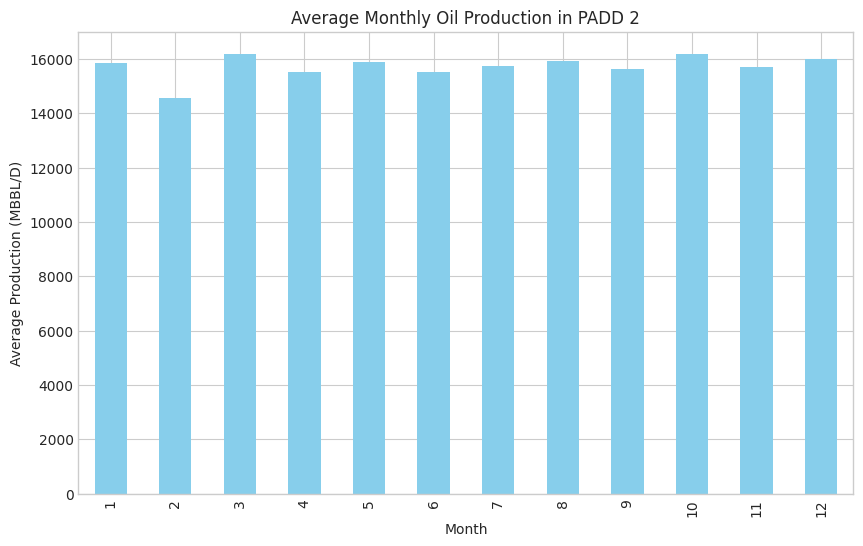

In [54]:
df_main['year'] =df_main['period'].dt.year
df_main['month'] = df_main['period'].dt.month
monthly_avg = df_main.groupby('month')['value'].mean()

plt.figure(figsize=(10,6))
monthly_avg.plot(kind='bar', color='skyblue')
plt.title('Average Monthly Oil Production in PADD 2')
plt.xlabel('Month')
plt.ylabel('Average Production (MBBL/D)')
plt.show()

This chart shows that oil production in PADD 2 experienced a gradual decline from the early 1980s to around 2005, after which there was a sharp and sustained increase through the 2010s, reaching prominent peaks around 2015 and 2019. Post-2019, production displays notable volatility, especially around the COVID-19 pandemic period, before stabilizing at elevated but less volatile levels through 2025. There is no distinct seasonality visible, indicating production fluctuations are primarily shaped by long-term economic and regulatory dynamics rather than short-term seasonal effects.

In [55]:
pivot_df.reset_index().to_csv('../data/cleaned/oil_production_cleaned.csv', index=False)